In [6]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import Model
#importlib.reload(Model)
import utils
import config

Dataset 1/22 - Session Exp_2025-05-27/E8331D05289A/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.06%
Maximum validation accuracy : 91.0%


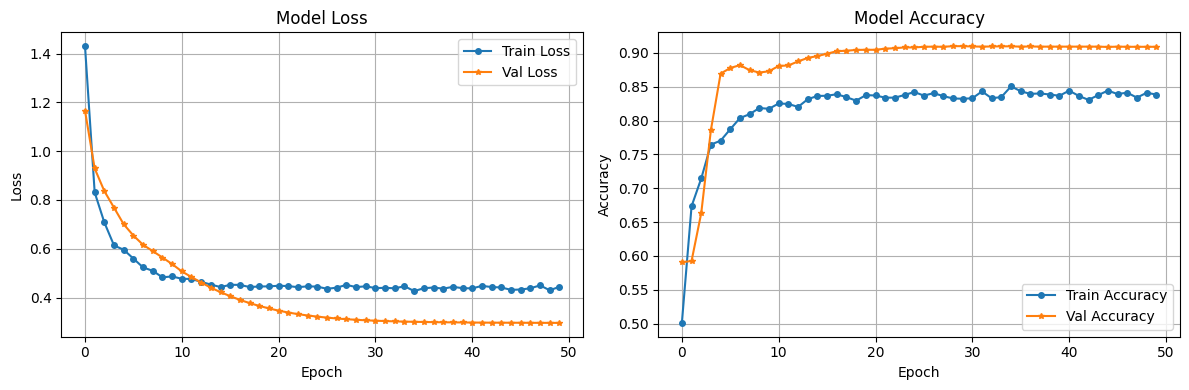

Dataset 2/22 - Session Exp_2025-06-18/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.24%
Maximum validation accuracy : 88.77%


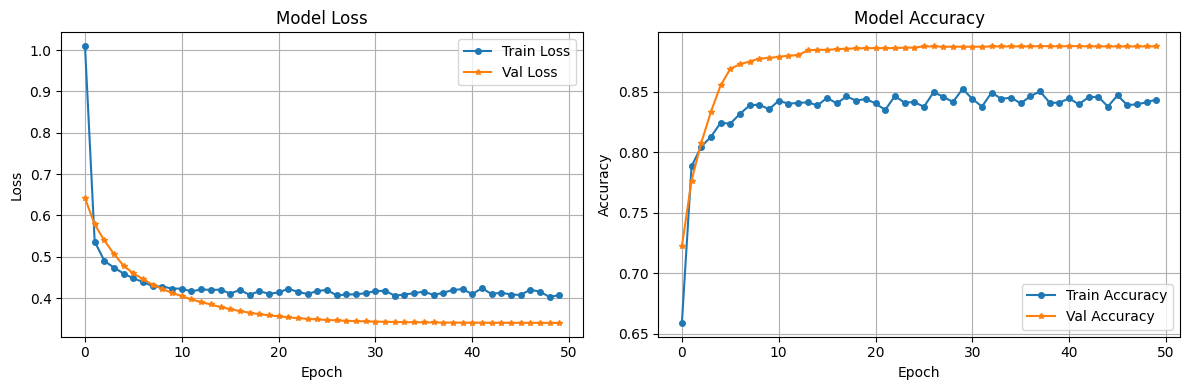

Dataset 3/22 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 84.49%
Maximum validation accuracy : 92.22%


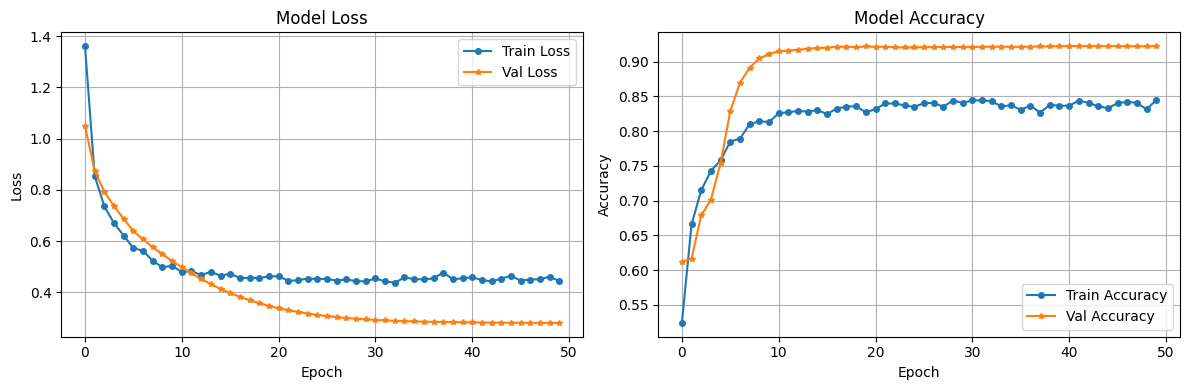

Dataset 4/22 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 86.86%
Maximum validation accuracy : 92.11%


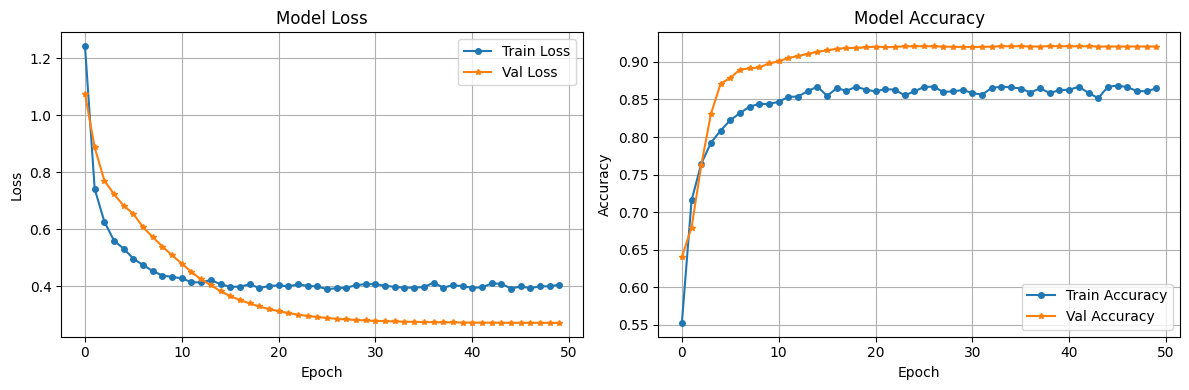

Dataset 5/22 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.8%
Maximum validation accuracy : 92.87%


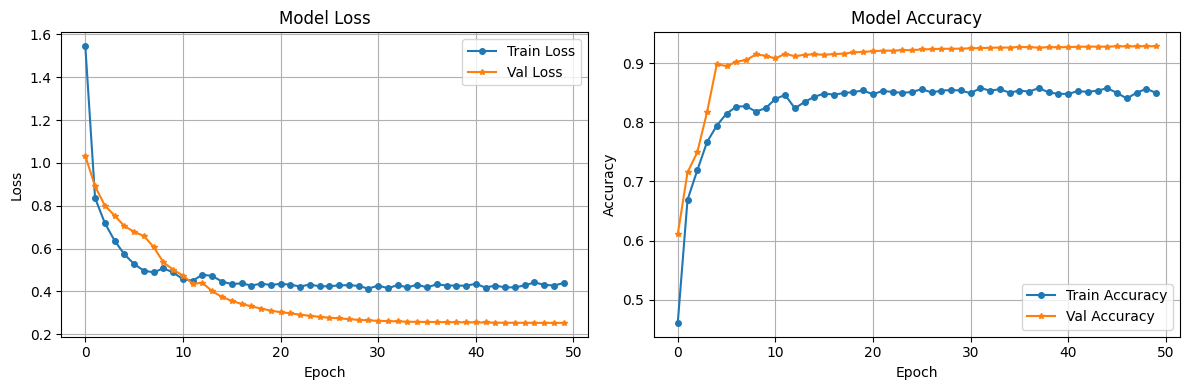

Dataset 6/22 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 82.39%
Maximum validation accuracy : 86.4%


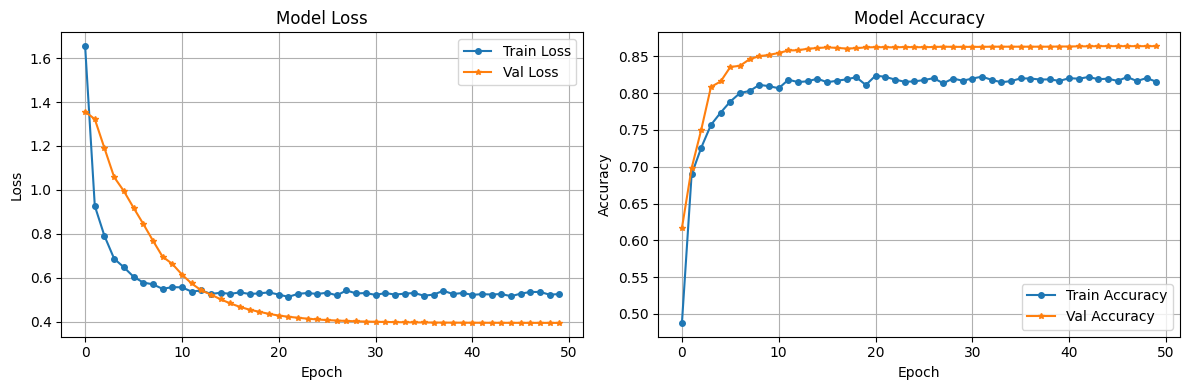

Dataset 7/22 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 86.24%
Maximum validation accuracy : 94.41%


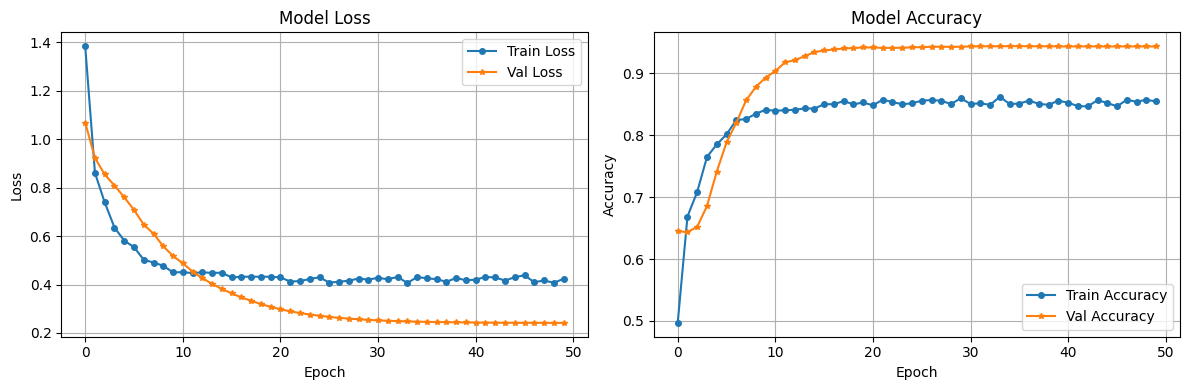

Dataset 8/22 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 80.59%
Maximum validation accuracy : 86.15%


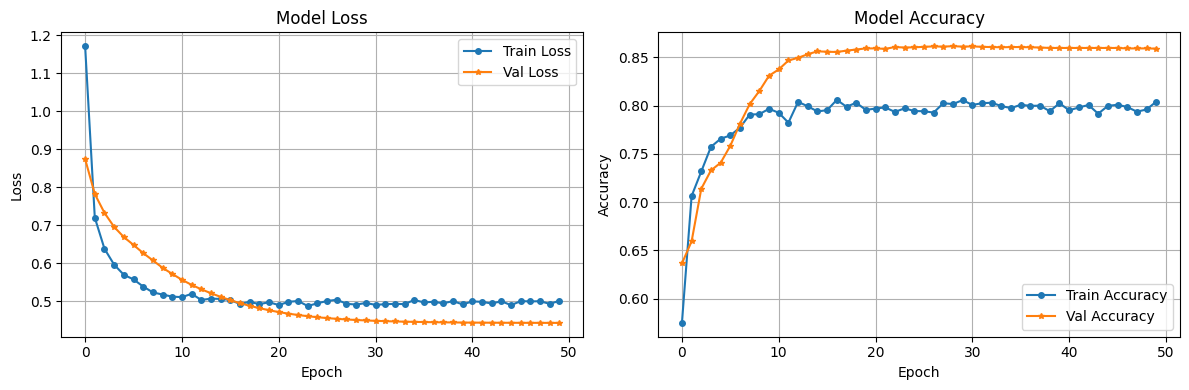

Dataset 9/22 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 81.71%
Maximum validation accuracy : 90.38%


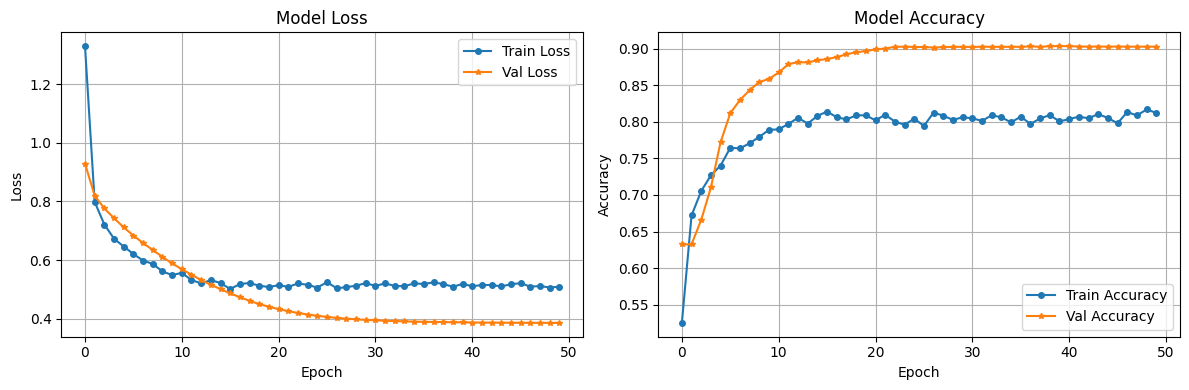

Dataset 10/22 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 86.29%
Maximum validation accuracy : 92.69%


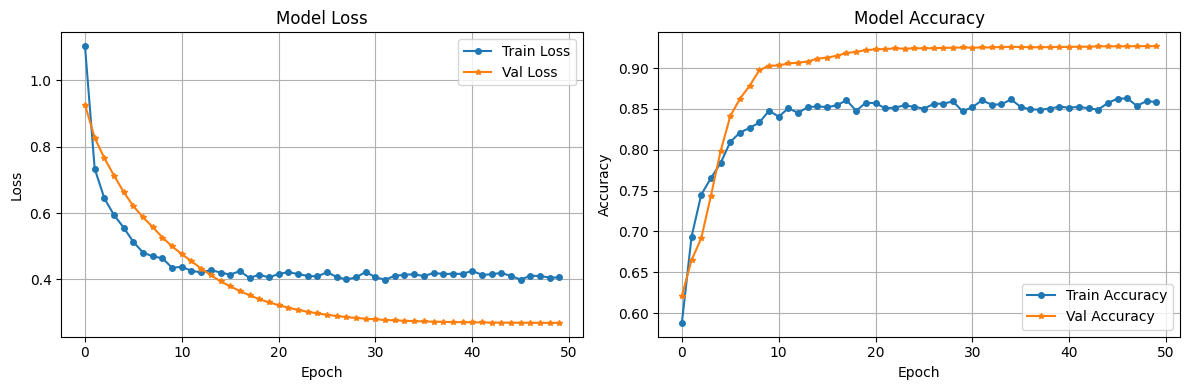

Dataset 11/22 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 88.08%
Maximum validation accuracy : 94.7%


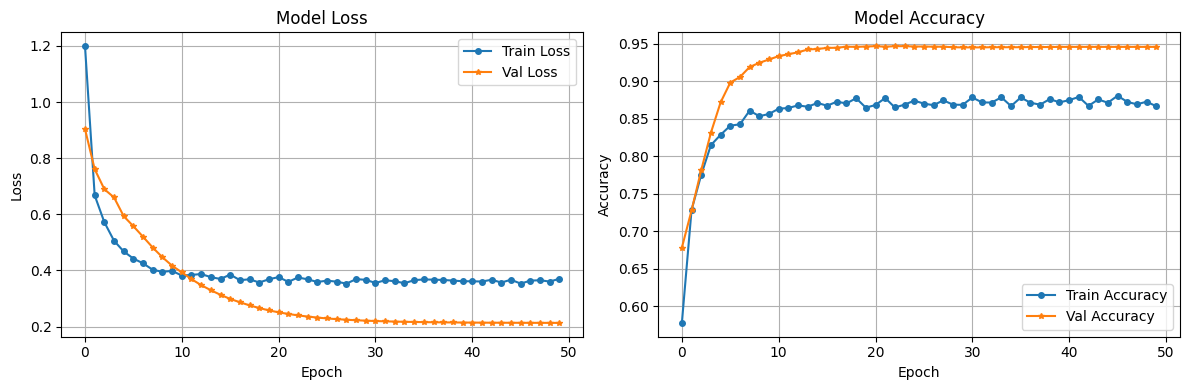

Dataset 12/22 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 87.31%
Maximum validation accuracy : 93.35%


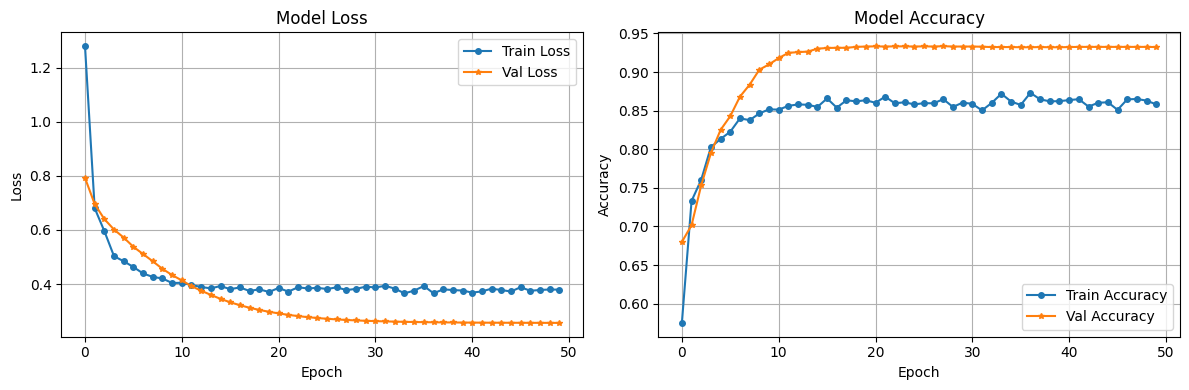

Dataset 13/22 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 83.05%
Maximum validation accuracy : 92.11%


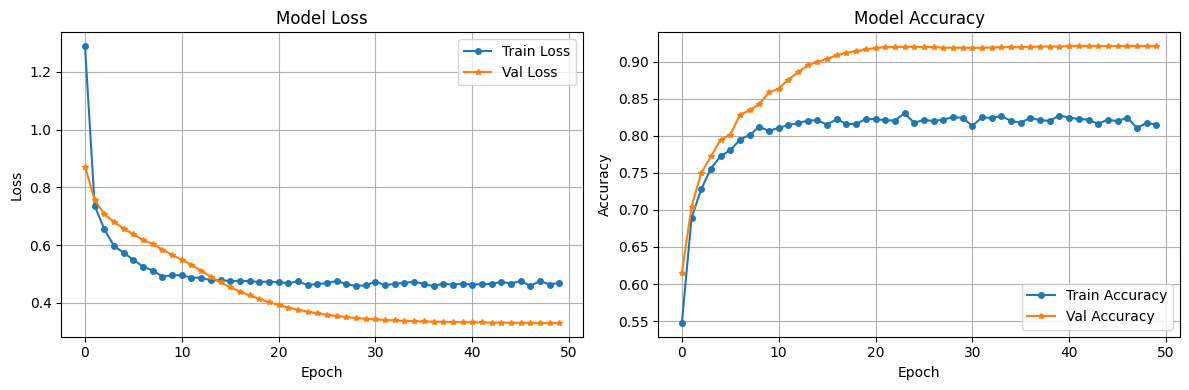

Dataset 14/22 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.46%
Maximum validation accuracy : 92.4%


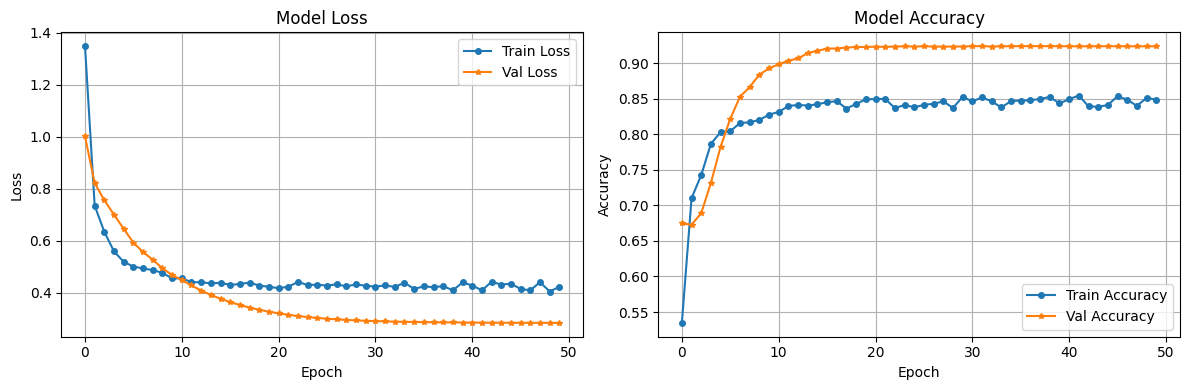

Dataset 15/22 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 89.37%
Maximum validation accuracy : 94.24%


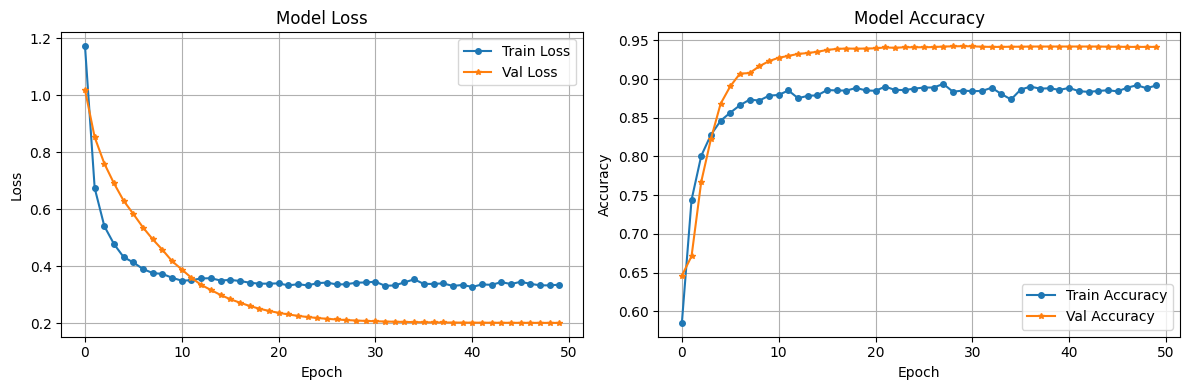

Dataset 16/22 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 88.48%
Maximum validation accuracy : 94.18%


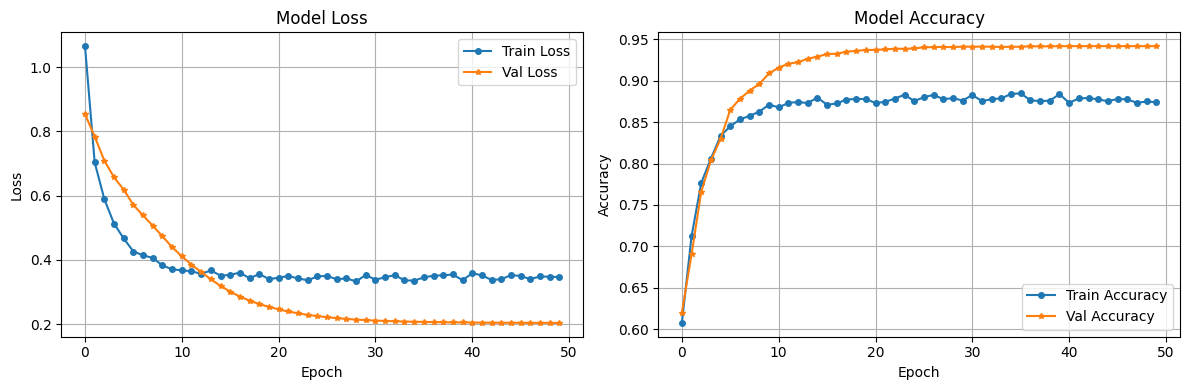

Dataset 17/22 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.8%
Maximum validation accuracy : 90.61%


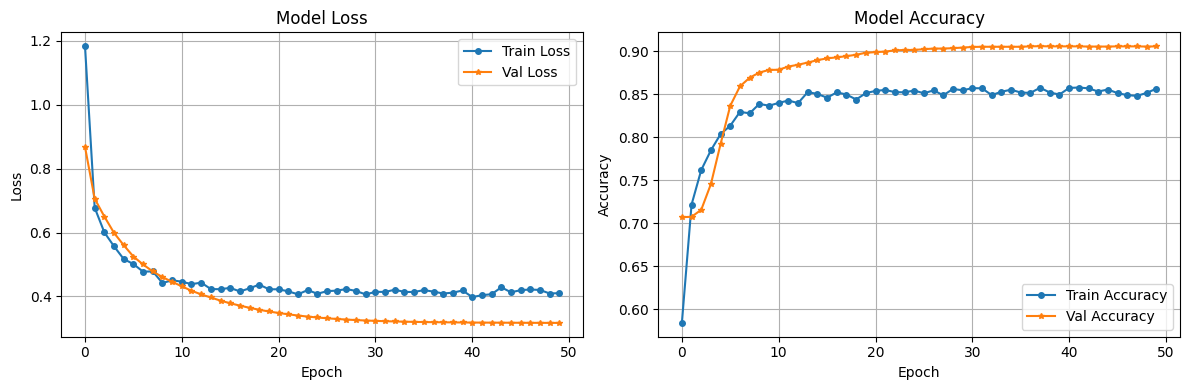

Dataset 18/22 - Session Exp_2025-06-24-v4/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.24%
Maximum validation accuracy : 93.16%


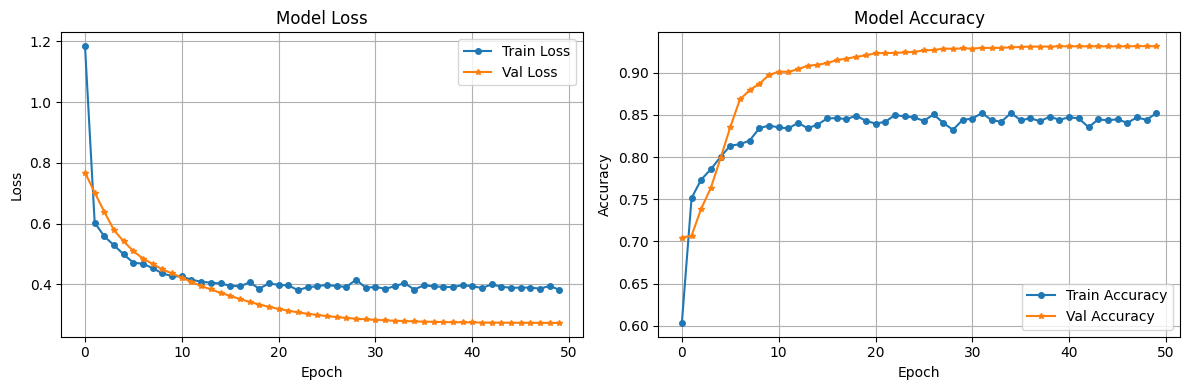

Dataset 19/22 - Session Exp_2025-06-26-v1/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 87.05%
Maximum validation accuracy : 94.26%


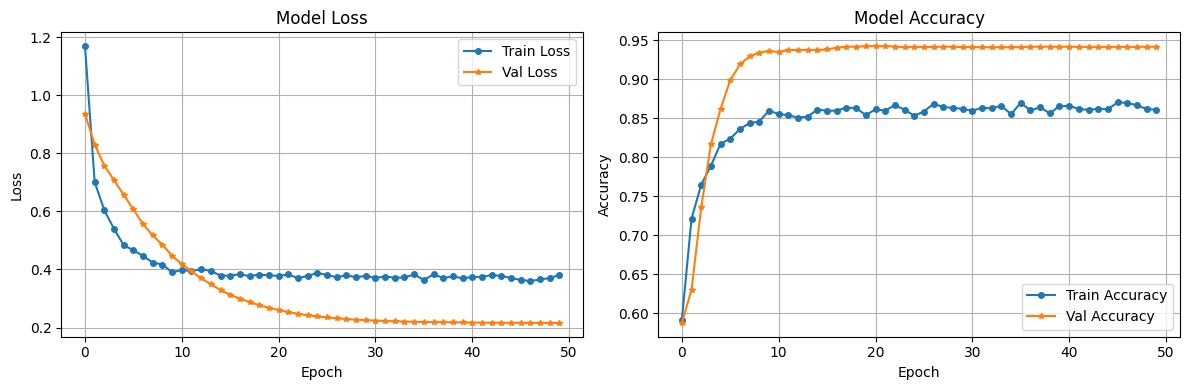

Dataset 20/22 - Session Exp_2025-06-26-v2/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 87.51%
Maximum validation accuracy : 93.88%


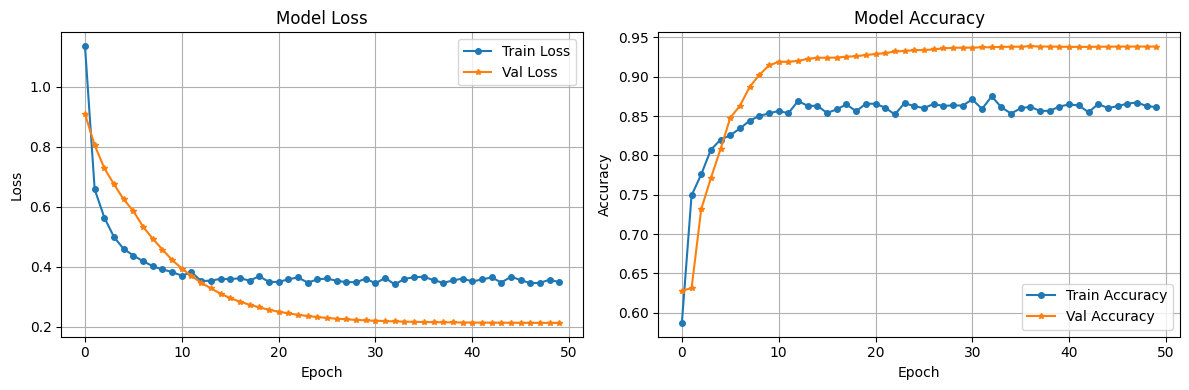

Dataset 21/22 - Session Exp_2025-06-26-v3/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 87.53%
Maximum validation accuracy : 93.42%


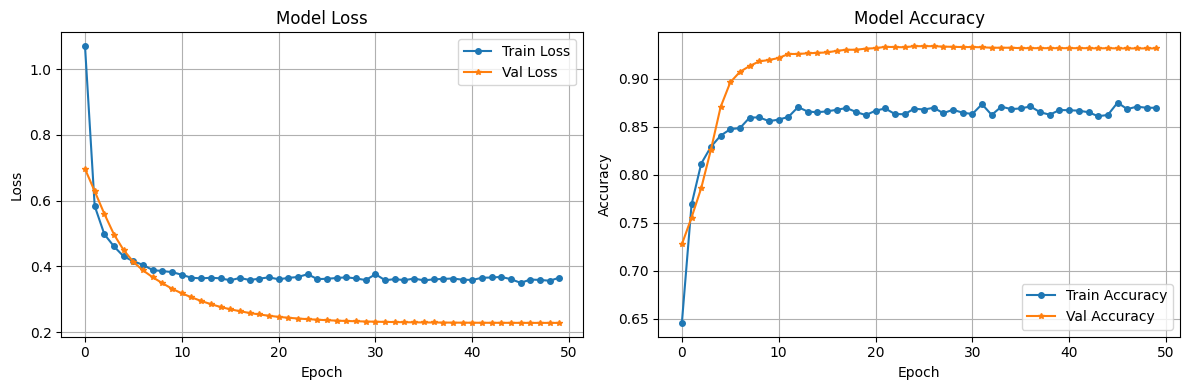

Dataset 22/22 - Session Exp_2025-06-26-v4/E9AD0E7DCC2B/

Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 87.24%
Maximum validation accuracy : 92.95%


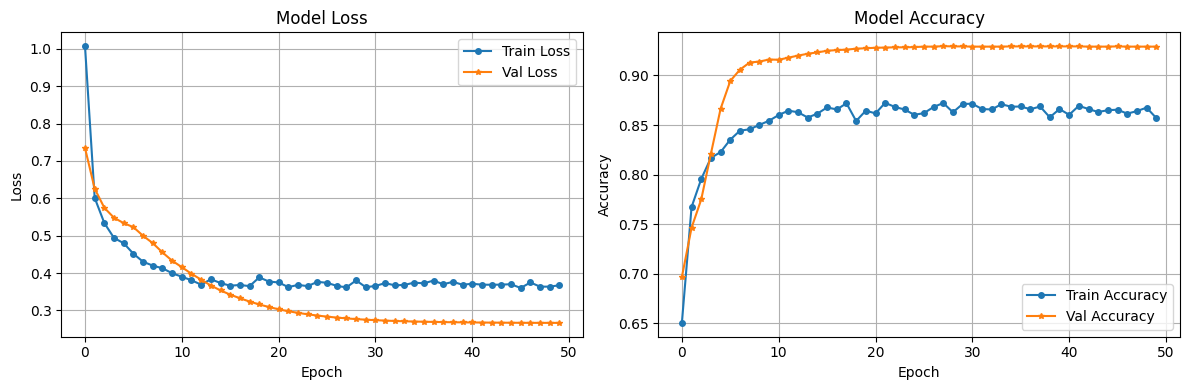

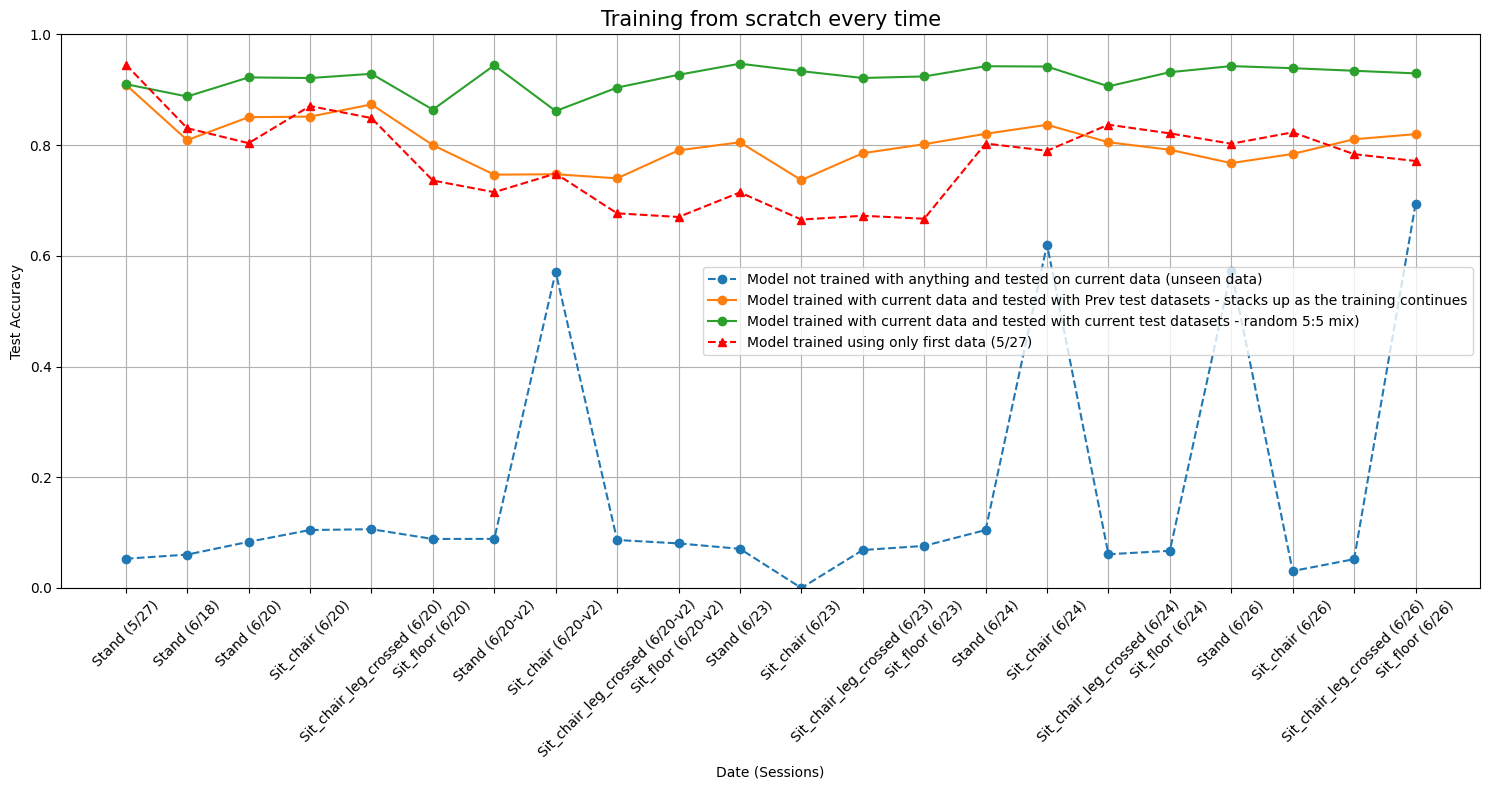

In [7]:


def get_result(path, classes, train_ratio, set_epoch, set_batch_size, Model_name, X_test_prev_all, y_test_prev_all, First_time):

    feature_set, labels = utils.get_dataset(path, classes, show_labels=False)
    X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=train_ratio)

    model = Model.Original_model_V1(X_train.shape[1:])
    init_acc = model.evaluate(X_test, y_test, verbose=0)[1]  #Before training
    #Init_acc_all.append(acc)

    history, _ = Model.Train_model(model, X_train, y_train, X_test, y_test, set_epoch, set_batch_size, Model_name, set_verbose=0, save_model_set=False)
    utils.visualize_history(history)
    test_acc = float(np.max(history.history['val_accuracy']))

    if First_time:
        X_test_prev_all = X_test
        y_test_prev_all = y_test

    else:
        X_test_prev_all = np.concatenate((X_test_prev_all, X_test), axis=0)
        y_test_prev_all = np.concatenate((y_test_prev_all, y_test), axis=0)

    Prev_acc = model.evaluate(X_test_prev_all, y_test_prev_all, verbose=0)[1]

    return init_acc, test_acc, Prev_acc, X_test_prev_all, y_test_prev_all



default_path = config.default_path
classes = config.classes

Info = config.Info
dataset = config.dataset

Trained_acc_all, Prev_acc_all, Init_acc_all = [], [], []
X_test_prev_all, y_test_prev_all = [], []
set_epoch, set_batch_size = 50, 256
train_ratio = 0.5
Model_name = "Training_from_scratch"

for idx, sessions in enumerate(dataset):
    print(f"===========================================\nDataset {idx+1}/{len(dataset)} - Session {sessions}\n===========================================\n")
    path = default_path + sessions + 'raw/'
    if idx == 0:
        bool_val = True
    else:
        bool_val = False

    init_acc, test_acc, Prev_acc, X_test_prev_all, y_test_prev_all = get_result(path, classes, train_ratio, set_epoch, set_batch_size, Model_name,
                                                                                X_test_prev_all, y_test_prev_all, First_time=bool_val)

    Init_acc_all.append(init_acc)
    Trained_acc_all.append(test_acc)
    Prev_acc_all.append(Prev_acc)


baseline = pd.read_csv('C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv')
#baseline.shape

plt.figure(figsize=(15, 8))
plt.title('Training from scratch every time', fontsize=15)
plt.plot(Info, Init_acc_all, marker='o', label='Model not trained with anything and tested on current data (unseen data)', linestyle='--')
plt.plot(Info, Prev_acc_all, marker='o', label='Model trained with current data and tested with Prev test datasets - stacks up as the training continues')
plt.plot(Info, Trained_acc_all, marker='o', label='Model trained with current data and tested with current test datasets - random 5:5 mix)')
plt.plot(Info, baseline['Accuracy']/100, marker='^', label='Model trained using only first data (5/27)', color='red', linestyle='--')
plt.ylim([0, 1])

plt.xlabel('Date (Sessions)')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import Model
#importlib.reload(Model)
import utils
import config


class ProgressiveTrainer:
    def __init__(self, config):
        self.default_path = config.default_path
        self.classes = config.classes
        self.dataset = config.dataset
        self.info = config.Info
        self.train_ratio = 0.5
        self.set_epoch = 50
        self.set_batch_size = 256
        self.model_name = "Training_from_scratch"

        self.trained_acc_all = []
        self.prev_acc_all = []
        self.init_acc_all = []
        self.X_test_prev_all = []
        self.y_test_prev_all = []

    def get_result(self, path, first_time, plot_learning_curve):
        feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=self.train_ratio)

        model = Model.Original_model_V1(X_train.shape[1:])
        init_acc = model.evaluate(X_test, y_test, verbose=0)[1]

        history, _ = Model.Train_model(
            model, X_train, y_train, X_test, y_test,
            self.set_epoch, self.set_batch_size, self.model_name,
            set_verbose=0, save_model_set=False
        )

        if plot_learning_curve:
            utils.visualize_history(history)

        test_acc = float(np.max(history.history['val_accuracy']))

        if first_time:
            self.X_test_prev_all = X_test
            self.y_test_prev_all = y_test
        else:
            self.X_test_prev_all = np.concatenate((self.X_test_prev_all, X_test), axis=0)
            self.y_test_prev_all = np.concatenate((self.y_test_prev_all, y_test), axis=0)

        prev_acc = model.evaluate(self.X_test_prev_all, self.y_test_prev_all, verbose=0)[1]

        return init_acc, test_acc, prev_acc

    def run(self, plot_learning_curve=False):
        for idx, session in enumerate(self.dataset):
            print(f"\n{'='*43}\nDataset {idx+1}/{len(self.dataset)} - Session {session}\n{'='*43}")
            path = os.path.join(self.default_path, session + 'raw/')
            first_time = (idx == 0)
            init_acc, test_acc, prev_acc = self.get_result(path, first_time, plot_learning_curve)

            self.init_acc_all.append(init_acc)
            self.trained_acc_all.append(test_acc)
            self.prev_acc_all.append(prev_acc)

        return self.init_acc_all, self.trained_acc_all, self.prev_acc_all


    def plot_results(self, baseline_csv_path, baseline2_csv_path):
        baseline = pd.read_csv(baseline_csv_path)
        baseline2 = pd.read_csv(baseline2_csv_path)

        plt.figure(figsize=(15, 8))
        plt.title('Training from scratch every time', fontsize=15)
        plt.plot(self.info, self.init_acc_all, marker='o', label='Untrained model on current data', linestyle='--')
        plt.plot(self.info, self.prev_acc_all, marker='o', label='Model trained + tested on accumulated data')
        plt.plot(self.info, self.trained_acc_all, marker='o', label='Model trained + tested on current split')
        plt.plot(self.info, baseline['Accuracy'] / 100, marker='^', label='Baseline (first session only)', color='red', linestyle='--')
        plt.plot(self.info, baseline2['Accuracy'] / 100, marker='^', label='Baseline - v2 (first session only)', linestyle='--')

        plt.ylim([0, 1])
        plt.xlabel('Date (Sessions)')
        plt.ylabel('Test Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
prog_trainer = ProgressiveTrainer(config)
Init_acc_all, Prev_acc_all, Trained_acc_all = prog_trainer.run(plot_learning_curve=False)


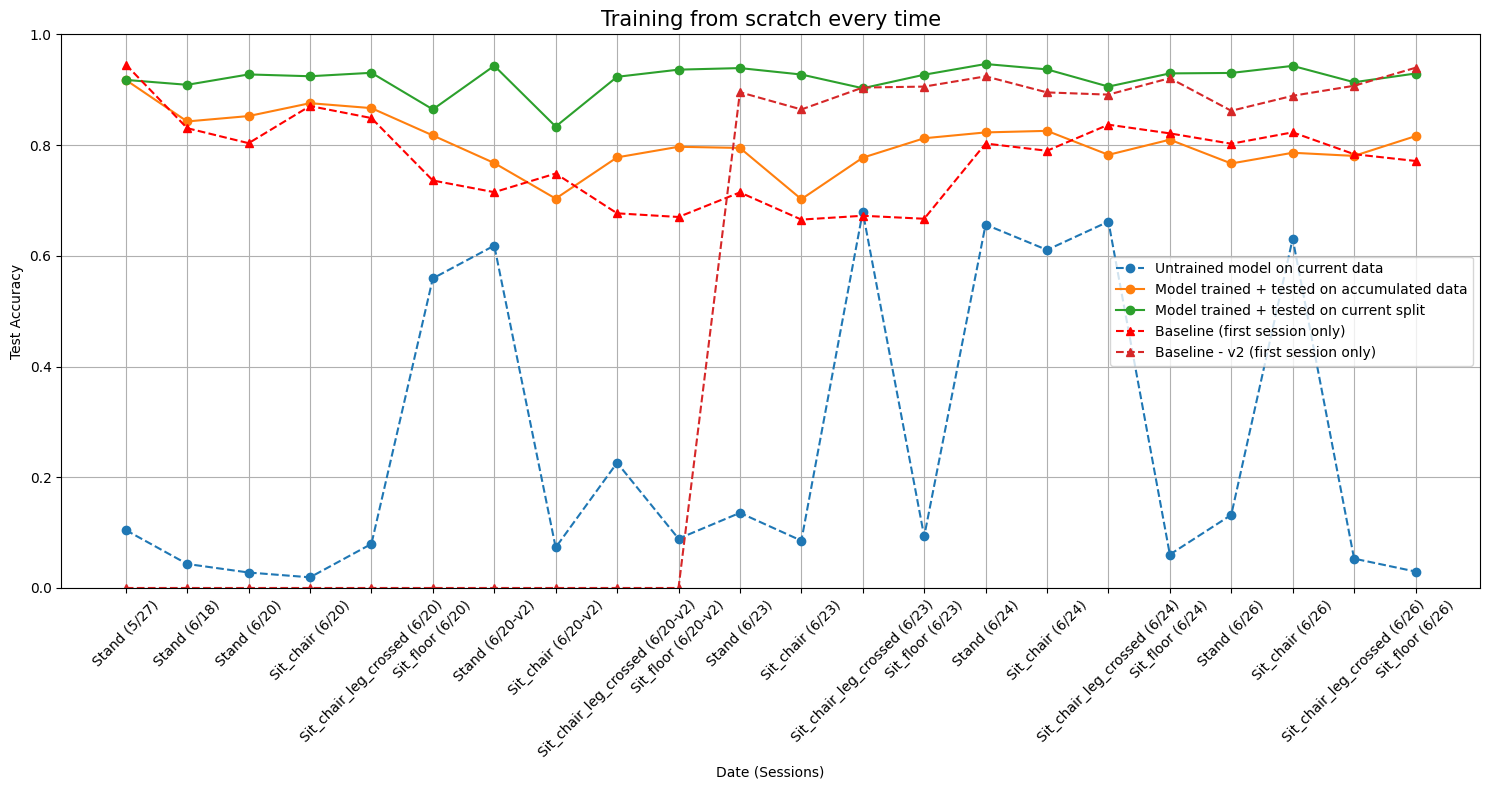

Average of acc without training anything (should be random): 25.77%
Average of acc using previous test data after training: 92.00%
Average of acc using current test data after training: 80.43%


In [13]:
baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv'
baseline2_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_10data.csv'
prog_trainer.plot_results(baseline1_csv_path, baseline2_csv_path)

for idx, x in enumerate([Init_acc_all, Prev_acc_all, Trained_acc_all]):
    if idx==0:
        print(f"Average of acc without training anything (should be random): {np.mean(x)*100:.2f}%")
    elif idx==1:
        print(f"Average of acc using previous test data after training: {np.mean(x)*100:.2f}%")
    elif idx==2:
        print(f"Average of acc using current test data after training: {np.mean(x)*100:.2f}%")